## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

## 第一次訓練

In [1]:
import os
import keras

from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

import matplotlib.pyplot as plt
%matplotlib inline

# resnet_builder.py
from keras.models import Model
from keras import backend as K
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, AveragePooling2D
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.optimizers import RMSprop, Adam
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
# 讀取資料集並作前處理
( x_train, y_train ), ( x_test, y_test ) = cifar10.load_data( )
print( 'x_train shape : ', x_train.shape )
print( x_train.shape[0], 'train samples' )
print( x_test.shape[0], 'test samples' )

# 資料標準化
x_train = x_train.astype( 'float32' )
x_test = x_test.astype( 'float32' )
x_train = x_train / 255.
x_test = x_test / 255.

# 獨熱編碼
num_classes = 10
y_train = to_categorical( y_train, num_classes )
y_test = to_categorical( y_test, num_classes )

170500096/170498071 [==============================] - 2s 0us/step
x_train shape :  (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
def resnet_layer( inputs,
                        num_filters = 16,
                        kernel_size = 3,
                        strides = 1,
                        activation = 'relu',
                        batch_normalization=True,
                        conv_first = True ) :
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D( num_filters,
                            kernel_size = kernel_size,
                            strides = strides,
                            padding = 'same',
                            kernel_initializer = 'he_normal',
                            kernel_regularizer = l2(1e-4) 
                            )

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization( )( x )
        if activation is not None:
            x = Activation( activation )( x )
    else:
        if batch_normalization:
            x = BatchNormalization( )( x )
        if activation is not None:
            x = Activation( activation )( x )
        x = conv( x )
    return x

In [0]:
def resnet( input_shape, depth =11, num_classes = 10 ) :
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization( )(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model( inputs = inputs, outputs = outputs )
    return model

In [5]:
model = resnet( input_shape = ( 32, 32, 3 ) ) 
model.summary( )

W0809 10:36:02.013258 140100567476096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 10:36:02.052336 140100567476096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 10:36:02.060939 140100567476096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0809 10:36:02.132625 140100567476096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0809 10:36:02.133835

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
# 設定超參數
Learning_Rate = 0.01
Batch_Size = 128 
Epochs = 10 

In [7]:
# 訓練模型
model.compile( loss = 'categorical_crossentropy',
                      optimizer = Adam( lr = Learning_Rate ),
                      metrics = [ 'accuracy' ] 
                      )

history = model.fit( x_train, y_train,
                           batch_size = Batch_Size,
                           epochs = Epochs,                         
                           validation_data = ( x_test, y_test ), 
                           verbose = 1
                           )

score = model.evaluate( x_test, y_test, verbose = 0 )

print( 'Test loss : ', score[0] )
print( 'Test accuracy : ', score[1] )

W0809 10:36:03.660736 140100567476096 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0809 10:36:03.975455 140100567476096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 726s 15ms/step - loss: 1.7168 - acc: 0.4219 - val_loss: 1.9962 - val_acc: 0.3444
Epoch 2/10
50000/50000 [==============================] - 723s 14ms/step - loss: 1.3931 - acc: 0.5454 - val_loss: 1.6941 - val_acc: 0.4313
Epoch 3/10
50000/50000 [==============================] - 723s 14ms/step - loss: 1.2771 - acc: 0.5969 - val_loss: 2.3248 - val_acc: 0.3243
Epoch 4/10
50000/50000 [==============================] - 720s 14ms/step - loss: 1.2033 - acc: 0.6249 - val_loss: 2.0713 - val_acc: 0.4029
Epoch 5/10
50000/50000 [==============================] - 715s 14ms/step - loss: 1.1512 - acc: 0.6452 - val_loss: 3.3021 - val_acc: 0.1858
Epoch 6/10
50000/50000 [==============================] - 713s 14ms/step - loss: 1.1186 - acc: 0.6608 - val_loss: 1.9887 - val_acc: 0.4544
Epoch 7/10
50000/50000 [==============================] - 710s 14ms/step - loss: 1.0802 - acc: 0.6738 - val_loss: 1.

In [0]:
# 儲存 model
from keras.models import Model

model.save( 'model_1st.h5' )

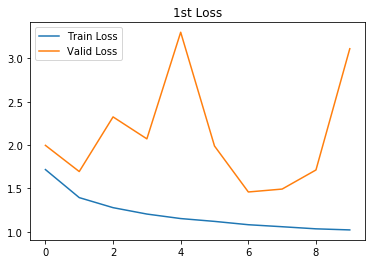

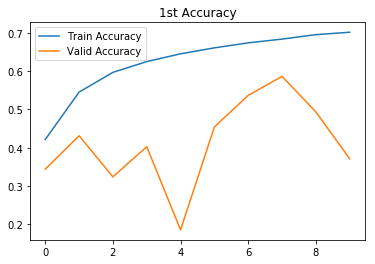

In [9]:
train_loss = model.history.history[ 'loss' ]
valid_loss = model.history.history[ 'val_loss' ]
train_acc = model.history.history[ 'acc' ]
valid_acc = model.history.history[ 'val_acc' ]

plt.plot( range( len( train_loss ) ), train_loss, label = 'Train Loss' )
plt.plot( range( len( valid_loss ) ), valid_loss, label = 'Valid Loss' )
plt.legend( )
plt.title( '1st Loss' )
plt.show( )

plt.plot( range( len( train_acc ) ), train_acc, label = 'Train Accuracy' )
plt.plot( range( len( valid_acc ) ), valid_acc, label = 'Valid Accuracy' )
plt.legend( )
plt.title( '1st Accuracy' )
plt.show( )

##  第二次訓練（調整參數） 
    * 降低學習率  
    * 資料增強
    

In [0]:
( x_train, y_train ), ( x_test, y_test ) = cifar10.load_data( )

num_classes = 10
y_train = keras.utils.to_categorical( y_train, num_classes )
y_test = keras.utils.to_categorical( y_test, num_classes )

In [0]:
# 若重開時需先load_model
#keras.models.load_model('model_1st.h5')

In [0]:
Learning_Rate = 0.001

In [0]:
model.compile( loss = 'categorical_crossentropy',
               optimizer = Adam( lr = Learning_Rate ),
               metrics = [ 'accuracy' ] )

In [0]:
# Data Augmentation

Data_Aug = ImageDataGenerator( rotation_range = 20,      # 隨機旋轉度數的範圍
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               horizontal_flip = True,   # 隨機水平翻轉
                               vertical_flip = False,    # 隨機垂直翻轉
                               featurewise_center = True,            # 將資料的均值設為 0
                               featurewise_std_normalization = True  # 資料標準化
                               )

Data_Agu.fit( x_train )

In [17]:
history = model.fit_generator( Data_Aug.flow( x_train, y_train, batch_size = Batch_Size ),
                               steps_per_epoch = x_train.shape[0] // Batch_Size,
                               epochs = Epochs,
                               verbose = 1,
                               validation_data = ( x_test, y_test ) 
                               )

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 788s 2s/step - loss: 1.1148 - acc: 0.6686 - val_loss: 1.0266 - val_acc: 0.6975
Epoch 2/10
390/390 [==============================] - 784s 2s/step - loss: 1.0480 - acc: 0.6902 - val_loss: 1.1560 - val_acc: 0.6662
Epoch 3/10
390/390 [==============================] - 779s 2s/step - loss: 1.0118 - acc: 0.6996 - val_loss: 1.0137 - val_acc: 0.7041
Epoch 4/10
390/390 [==============================] - 774s 2s/step - loss: 0.9765 - acc: 0.7091 - val_loss: 1.0356 - val_acc: 0.6966
Epoch 5/10
390/390 [==============================] - 768s 2s/step - loss: 0.9588 - acc: 0.7129 - val_loss: 1.0753 - val_acc: 0.6897
Epoch 6/10
390/390 [==============================] - 766s 2s/step - loss: 0.9386 - acc: 0.7202 - val_loss: 0.9742 - val_acc: 0.7115
Epoch 7/10
390/390 [==============================] - 770s 2s/step - loss: 0.9101 - acc: 0.7278 - val_loss: 1.0785 - val_acc: 0.6871
Epoch 8/10
390/390 [==============================] - 771s 2s/step - loss: 0.899

In [0]:
# 儲存model
model.save( 'model_2nd.h5' )

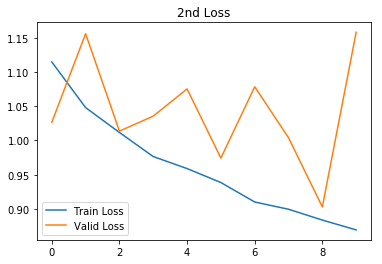

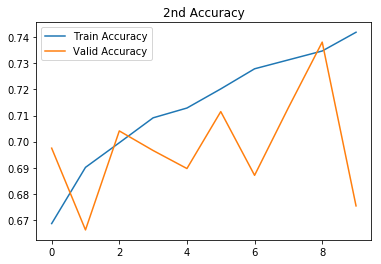

In [19]:
train_loss = model.history.history[ 'loss' ]
valid_loss = model.history.history[ 'val_loss' ]
train_acc = model.history.history[ 'acc' ]
valid_acc = model.history.history[ 'val_acc' ]

plt.plot( range( len( train_loss ) ), train_loss, label = 'Train Loss' )
plt.plot( range( len( valid_loss ) ), valid_loss, label = 'Valid Loss' )
plt.legend( )
plt.title( '2nd Loss' )
plt.show( )

plt.plot( range( len( train_acc ) ), train_acc, label = 'Train Accuracy' )
plt.plot( range( len( valid_acc ) ), valid_acc, label = 'Valid Accuracy' )
plt.legend( )
plt.title( '2nd Accuracy' )
plt.show( )